# 环境配置
第一步：设置python版本为3.9.0

In [1]:
%%capture captured_output
!/home/ma-user/anaconda3/bin/conda create -n python-3.9.0 python=3.9.0 -y --override-channels --channel https://mirrors.tuna.tsinghua.edu.cn/anaconda/pkgs/main
!/home/ma-user/anaconda3/envs/python-3.9.0/bin/pip install ipykernel

In [2]:
import json
import os

data = {
   "display_name": "python-3.9.0",
   "env": {
      "PATH": "/home/ma-user/anaconda3/envs/python-3.9.0/bin:/home/ma-user/anaconda3/envs/python-3.7.10/bin:/modelarts/authoring/notebook-conda/bin:/opt/conda/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/home/ma-user/modelarts/ma-cli/bin:/home/ma-user/modelarts/ma-cli/bin"
   },
   "language": "python",
   "argv": [
      "/home/ma-user/anaconda3/envs/python-3.9.0/bin/python",
      "-m",
      "ipykernel",
      "-f",
      "{connection_file}"
   ]
}

if not os.path.exists("/home/ma-user/anaconda3/share/jupyter/kernels/python-3.9.0/"):
    os.mkdir("/home/ma-user/anaconda3/share/jupyter/kernels/python-3.9.0/")

with open('/home/ma-user/anaconda3/share/jupyter/kernels/python-3.9.0/kernel.json', 'w') as f:
    json.dump(data, f, indent=4)

#### 注：以上代码运行完成后，需要重新设置kernel为python-3.9.0

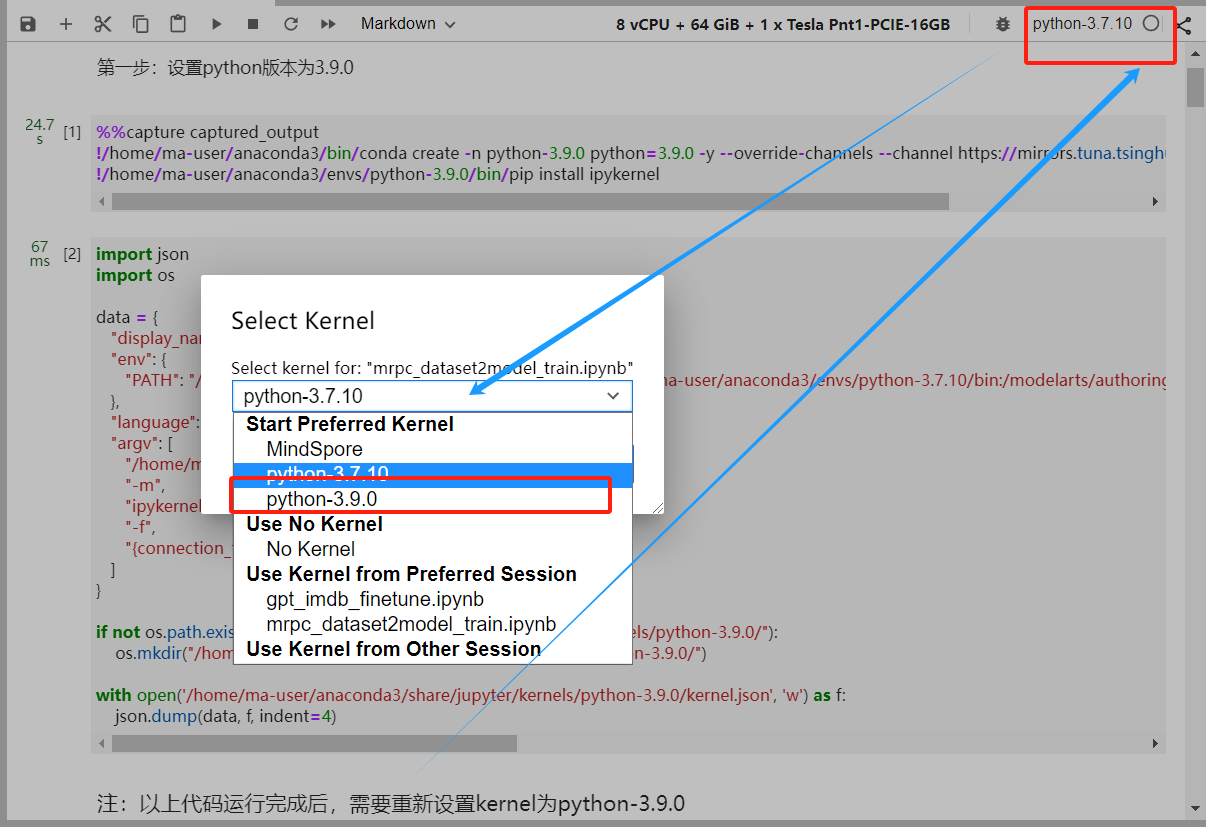



第二步：安装最新版本的MindSpore框架和MindNLP套件

In [1]:
!pip install https://ms-release.obs.cn-north-4.myhuaweicloud.com/2.3.1/MindSpore/unified/x86_64/mindspore-2.3.1-cp39-cp39-linux_x86_64.whl --trusted-host ms-release.obs.cn-north-4.myhuaweicloud.com -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 946.9/946.9 MB 61.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 17.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 8.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 6.3 MB/s eta 0:00:0000:0100:01


In [2]:
#安装mindnlp的daily包，待正式发布后可改为直接安装mindnlp包
!pip install https://repo.mindspore.cn/mindspore-lab/mindnlp/newest/any/mindnlp-0.4.0-py3-none-any.whl
# !pip install mindnlp==0.4.0

Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 30.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 782.0/782.0 kB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 87.1 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 101.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 58.7 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.4/737.4 kB 33.0 MB/s eta 0:00:00
  Created wheel for jieba: filename=jieba-0.42.1-py3-none-

In [1]:
!pip show mindspore

Name: mindspore
Version: 2.3.1
Summary: MindSpore is a new open source deep learning training/inference framework that could be used for mobile, edge and cloud scenarios.
Home-page: https://www.mindspore.cn
Author: The MindSpore Authors
Author-email: contact@mindspore.cn
License: Apache 2.0
Location: /home/ma-user/anaconda3/envs/python-3.9.0/lib/python3.9/site-packages
Requires: asttokens, astunparse, numpy, packaging, pillow, protobuf, psutil, scipy
Required-by: mindnlp


In [2]:
!pip show mindnlp

Name: mindnlp
Version: 0.4.0
Summary: An open source natural language processing research tool box. Git version: [sha1]:2fb76bf, [branch]: (HEAD, origin/master, origin/HEAD, master)
Home-page: https://github.com/mindlab-ai/mindnlp/tree/master/
Author: MindSpore Team
Author-email: 
License: Apache 2.0
Location: /home/ma-user/anaconda3/envs/python-3.9.0/lib/python3.9/site-packages
Requires: addict, datasets, evaluate, jieba, mindspore, ml-dtypes, pyctcdecode, pytest, regex, requests, safetensors, sentencepiece, tokenizers, tqdm
Required-by: 


# mrpc_dataset
<pre>
    MRPC数据集，全称为Microsoft Research Paraphrase Corpus（微软研究院释义语料库），是一个用于NLP的句对相似性判断任务中性能评估的数据集。
    MRPC数据集包含了大量从新闻、网页和论坛中收集的英文句子对。每个句子对都有一个人工标注的二元标签：0表示两句话不相似，1表示它们相似。
</pre>

##### 加载mrpc数据集并拆分成训练集、验证集、测试集

In [1]:
from mindnlp.dataset import load_dataset

/home/ma-user/anaconda3/envs/python-3.9.0/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.753 seconds.
Prefix dict has been built successfully.


In [29]:
mrpc_dict = load_dataset("SetFit/mrpc")   # 如果本地未下载会先下载，若已下载则会直接加载
mrpc_train = mrpc_dict['train']
mrpc_valid = mrpc_dict['validation']
mrpc_test = mrpc_dict['test']

Repo card metadata block was not found. Setting CardData to empty.
Generating train split: 3668 examples [00:00, 176571.87 examples/s]
Generating validation split: 408 examples [00:00, 48980.37 examples/s]
Generating test split: 1725 examples [00:00, 153982.47 examples/s]


In [3]:
# 打印每个数据集的样本数量
for k,v in mrpc_dict.items():
    print(f"{k}: {len(v)} samples")

train: 3668 samples
validation: 408 samples
test: 1725 samples


In [6]:
# 打印原数据集的样本格式及其内容
for dataDict in mrpc_train.create_dict_iterator():
    for col_name, data in dataDict.items():
        print(f"{col_name}: {data}")
    break

text1: Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .
text2: Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .
label: 1
idx: 0
label_text: equivalent


In [4]:
import json
import copy

from mindspore.dataset import NumpySlicesDataset, SequentialSampler

class InputExample(object):
    def __init__(self, guid, text_a, text_b=None, label=None):
        """
            InputExample表示单个输入示例
            包含一个全局唯一标识符（guid）、文本 A（text_a）、可选的文本 B（text_b）和标签（label）
        """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

    def __repr__(self):
        return str(self.to_json_string())

    def to_dict(self):
        """Serializes this instance to a Python dictionary."""
        output = copy.deepcopy(self.__dict__)
        return output

    def to_json_string(self):
        """Serializes this instance to a JSON string."""
        return json.dumps(self.to_dict(), indent=2, sort_keys=True) + "\n"    

class InputFeatures(object):
    def __init__(self, input_ids, attention_mask, token_type_ids, label, input_len):
        """
            InputFeatures 表示模型输入特征
            包含输入 ID（input_ids）、注意力掩码（attention_mask）、标记类型 ID（token_type_ids）、标签（label）和输入长度（input_len）
        """
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.token_type_ids = token_type_ids
        self.input_len = input_len
        self.label = label

    def __repr__(self):
        return str(self.to_json_string())

    def to_dict(self):
        """Serializes this instance to a Python dictionary."""
        output = copy.deepcopy(self.__dict__)
        return output

    def to_json_string(self):
        """Serializes this instance to a JSON string."""
        return json.dumps(self.to_dict(), indent=2, sort_keys=True) + "\n"

In [5]:
def convert_dataset_to_examples(ds):
    """
        Convert dataset to examples.
        将数据集ds转换为 InputExample 实例列表examples
        使用 mindspore.dataset 的迭代器遍历数据集，并将每个样本转换为 InputExample 对象。
    """
    examples = []
    iter0 = ds.create_tuple_iterator()
    #for i, (label, text_a, text_b) in enumerate(iter0):
    for i, (text_a, text_b, label, idx, label_text) in enumerate(iter0):
        # print(str(text_a.asnumpy()), str(text_b.asnumpy()))
        examples.append(
            InputExample(guid=i, text_a=str(text_a.asnumpy()), text_b=str(text_b.asnumpy()), label=int(label))
        )
    
    return examples

def _truncate_seq_pair(tokens_a, tokens_b, max_length):
    """
        Truncates a sequence pair in place to the maximum length.
        即保持文本对的意义，同时截断文本对，使其总长度不超过指定的最大长度max_length
    """
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        # 优先选择文本更长的文本进行截断
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()

In [6]:
def convert_examples_to_features(examples, tokenizer, max_seq_length=512):
    """
        将 InputExample 实例列表转换为 InputFeatures 实例列表。
        使用 tokenizer 对文本进行编码，生成模型输入所需的特征。
    """
    features = []

    for ex_index, example in enumerate(examples):
        tokenizer.return_token = True
        tokens_a = tokenizer(example.text_a)
        tokens_b  = None
        if example.text_b:
            tokens_b = tokenizer(example.text_b)
        if tokens_b is not None:
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)
        else:
            # Account for [CLS] and [SEP] with "- 2"
            if len(tokens_a) > max_seq_length - 2:
                tokens_a = tokens_a[0:(max_seq_length - 2)]

        tokens = []
        token_type_ids = []
        for token in tokens_a:
            tokens.append(token)
            token_type_ids.append(0)

        if tokens_b is not None:
            for token in tokens_b[1:]:
                tokens.append(token)
                token_type_ids.append(1)
            # tokens.append("[SEP]")
            # token_type_ids.append(1)

        tokenizer.return_token=False
        # input_ids = tokenizer.execute_py(example.text_a).tolist() + tokenizer.execute_py(example.text_b).tolist()
        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # print(tokenizer.execute_py(np.array(tokens)).tolist())
        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        attention_mask = [1] * len(input_ids)
        input_len = len(input_ids)

        # Zero-pad up to the sequence length.
        while len(input_ids) < max_seq_length:
            input_ids.append(0)
            attention_mask.append(0)
            token_type_ids.append(0)

        assert len(input_ids) == max_seq_length
        assert len(attention_mask) == max_seq_length
        assert len(token_type_ids) == max_seq_length
        
        label_id = example.label

        # if ex_index < 5:
        #     print("*** Example ***")
        #     print("guid: %s" % (example.guid))
        #     print("tokens: %s"%" ".join([str(x) for x in tokens]))
        #     print("input_ids: %s" % " ".join([str(x) for x in input_ids]))
        #     print("attention_mask: %s" % " ".join([str(x) for x in attention_mask]))
        #     print("token_type_ids: %s" % " ".join([str(x) for x in token_type_ids]))
        #     print("label: %s (id = %d)" % (example.label, label_id))
        #     print("input length: %d" % (input_len))

        features.append(
            InputFeatures(input_ids=input_ids,
                          attention_mask=attention_mask,
                          token_type_ids=token_type_ids,
                          label=label_id,
                          input_len=input_len)
        )
    return features


In [7]:
def load_examples(tokenizer, max_seq_length, mrpc_datas):
    """load_examples using load_dataset
        加载数据集并转换为模型训练所需的特征：
            首先加载 MRPC 数据集的指定部分（训练或测试）
            然后调用 convert_examples_to_features 函数转换为模型输入所需的特征
    """
    
    train_examples = convert_dataset_to_examples(mrpc_datas)

    features = convert_examples_to_features(train_examples, tokenizer, max_seq_length=max_seq_length)

    # Convert to Tensors and build dataset
    all_input_ids = [f.input_ids for f in features]
    all_attention_mask = [f.attention_mask for f in features]
    all_token_type_ids = [f.token_type_ids for f in features]
    all_lens = [f.input_len for f in features]
    all_labels = [f.label for f in features]
    dataset = ((all_input_ids, all_attention_mask, all_token_type_ids, all_lens, all_labels))

    return dataset

def get_dataloader_from_ds(ds, batch_size):
    train_sampler = SequentialSampler()  # 应用 SequentialSampler 以顺序方式采样数据
    col_names = ['input_ids', 'attention_mask', 'token_type_ids', 'lens', 'labels']
    train_dataloader = NumpySlicesDataset(ds, sampler=train_sampler, column_names=col_names)  # 使用 NumpySlicesDataset 包装数据集
    train_dataloader = train_dataloader.batch(batch_size)  # 根据指定批次大小 进行 批处理

    return train_dataloader

<b>此次将使用GPT2的词汇表对数据集的样本特征进行token转换</b>

In [9]:
from mindnlp.transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
# add sepcial token: <PAD>
special_tokens_dict = {
    "bos_token": "<bos>",
    "eos_token": "<eos>",
    "pad_token": "<pad>",
}
num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)
print(num_added_toks)

100%|██████████| 26.0/26.0 [00:00<00:00, 134kB/s]
0.99MB [00:00, 3.22MB/s]
446kB [00:00, 1.77MB/s]
1.29MB [00:00, 4.27MB/s]


3


In [3]:
# 此次实验的指定的一些超参数
class Args:
    save_dir=".mindnlp/peft_model/mrpc_IA3"   # The output directory where the model checkpoints will be written.
    batch_size = 8  # Batch size per GPU/CPU for training
    model_name_or_path = "gpt2"   
    num_epochs = 5
    lr = 2e-5    # learning rate
    max_seq_len = 256
    debug = True
    is_lora = True

args = Args()

In [10]:
# load dataset, 将每个样本转换为GPT2模型输入的正确格式
train_ds = load_examples(tokenizer, args.max_seq_len, mrpc_train)
valid_ds = load_examples(tokenizer, args.max_seq_len, mrpc_valid)
test_ds = load_examples(tokenizer, args.max_seq_len, mrpc_test)

In [11]:
# 转换为mindspore框架下数据加载器（包含批量处理）
train_dataloader = get_dataloader_from_ds(train_ds, args.batch_size)
valid_dataloader = get_dataloader_from_ds(valid_ds, args.batch_size)
test_dataloader = get_dataloader_from_ds(test_ds, args.batch_size)

In [12]:
train_dataloader.get_col_names()   # 数据集样本的列名

['input_ids', 'attention_mask', 'token_type_ids', 'lens', 'labels']

# 加载预训练模型并进行微调

In [13]:
import os
import mindspore
import numpy as np

from tqdm import tqdm 
from mindspore.nn import AdamWeightDecay

In [ ]:
from mindnlp.transformers import  GPT2ForSequenceClassification

In [17]:
model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels = 2)

100%|██████████| 523M/523M [00:32<00:00, 16.7MB/s] 
100%|██████████| 124/124 [00:00<00:00, 365kB/s]
The following parameters in models are missing parameter:
['score.weight']


In [16]:
model.config.pad_token_id = tokenizer.pad_token_id
model.resize_token_embeddings(model.config.vocab_size + num_added_toks)

Embedding<vocab_size=50260, embedding_size=768, use_one_hot=False, weight=Parameter (Tensor(shape=[50260, 768], dtype=Float32, value=[...], name=wte.weight), requires_grad=True), dtype=Float32, padding_idx=None>

给出的例子中微调算法采用IA3, 该算法通过学习向量来对激活层加权进行缩放，从而获得更强的性能，同时仅引入相对少量的新参数。

In [6]:
from mindnlp.peft import LoraConfig, get_peft_model
from mindnlp.peft import TaskType

In [7]:
if args.is_lora:
    # build peft model
    peft_config = LoraConfig(task_type=TaskType.SEQ_CLS, inference_mode=False, r=8, lora_alpha=32, lora_dropout=0.1, fan_in_fan_out=True)
    model = get_peft_model(model, peft_config)
    # print(model)
    model.print_trainable_parameters()

trainable params: 296,448 || all params: 124,737,792 || trainable%: 0.23765692437461133


In [19]:
from mindnlp._legacy.engine import Trainer, Evaluator
from mindnlp._legacy.metrics import Accuracy
from mindnlp._legacy.engine.callbacks import CheckpointCallback, BestModelCallback

In [21]:
# optimizer
optimizer = AdamWeightDecay(params=model.trainable_params(), learning_rate=args.lr)

metric = Accuracy()
ckpoint_cb = CheckpointCallback(save_path=args.save_dir, ckpt_name='gpt2_mrpc_finetune', epochs=1, keep_checkpoint_max=2)
best_model_cb = BestModelCallback(save_path=args.save_dir, ckpt_name='gpt2_mrpc_finetune_best', auto_load=True)

if args.debug:
    args.num_epochs = 2

trainer = Trainer(network=model, train_dataset=train_dataloader,
                  eval_dataset=valid_dataloader, metrics=metric,
                  epochs=args.num_epochs, optimizer=optimizer, 
                  callbacks=[ckpoint_cb, best_model_cb],
                  jit=False)

In [22]:
trainer.run(tgt_columns="labels")

The train will start from the checkpoint saved in '.mindnlp/peft_model/mrpc_IA3'.


Epoch 0: 100%|██████████| 459/459 [03:05<00:00,  2.47it/s, loss=0.6872016] 


Checkpoint: 'gpt2_mrpc_finetune_epoch_0.ckpt' has been saved in epoch: 0.


Evaluate: 100%|██████████| 51/51 [00:07<00:00,  7.18it/s]


Evaluate Score: {'Accuracy': 0.6838235294117647}
---------------Best Model: 'gpt2_mrpc_finetune_best.ckpt' has been saved in epoch: 0.---------------


Epoch 1: 100%|██████████| 459/459 [03:04<00:00,  2.49it/s, loss=0.6677042] 


Checkpoint: 'gpt2_mrpc_finetune_epoch_1.ckpt' has been saved in epoch: 1.


Evaluate: 100%|██████████| 51/51 [00:07<00:00,  7.21it/s]


Evaluate Score: {'Accuracy': 0.6838235294117647}
Loading best model from '.mindnlp/peft_model/mrpc_IA3' with '['Accuracy']': [0.6838235294117647]...
---------------The model is already load the best model from 'gpt2_mrpc_finetune_best.ckpt'.---------------


In [23]:
evaluator = Evaluator(network=model, eval_dataset=test_dataloader, metrics=metric)
evaluator.run(tgt_columns="labels")

Evaluate: 100%|██████████| 216/216 [00:30<00:00,  7.13it/s]

Evaluate Score: {'Accuracy': 0.664927536231884}
